# Imports

In [1]:
from importlib import reload
import json
import logging
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import datasets
from model import CNN

import utils
reload(utils)

c:\Users\pkbab\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<module 'utils' from 'c:\\Users\\pkbab\\Documents\\code\\2023-Project-120\\code\\utils.py'>

# Hyperparameters

In [2]:
layers = 1
batch_size = 64
log_frequency = 10
channels = 16
unrolled = False
visualization = False

# Getting dataset

In [3]:
dataset = "fashionmnist"

dataset_train, dataset_valid = datasets.get_dataset(dataset)        

# Architecture search for a range of $\lambda$

In [6]:
epochs = 10
lambd = 1
n_chosen = 1

for weight in [1e2]:
    for lambd in [2, 3, 4]:
        print(f"weight = {weight}, lambd = {lambd}")
        if dataset == "fashionmnist":
            model = CNN(32, 1, channels, 10, layers, n_chosen=1)
        if dataset == "cifar10":
            model = CNN(32, 3, channels, 10, layers, n_chosen=1)

        criterion = nn.CrossEntropyLoss() # mycriterion()
        optim = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, epochs, eta_min=0.001)
        trainer = utils.MyDartsTrainer( # MyDartsTrainer
            model=model,
            loss=criterion, # =mycriterion,
            metrics=lambda output, target: utils.accuracy(output, target, topk=(1,)),
            optimizer=optim,
            num_epochs=epochs,
            dataset=dataset_train,
            batch_size=batch_size,
            log_frequency=log_frequency,
            unrolled=unrolled,
            weight=1e3, # вес регуляризатора
            lambd=lambd, # количество общих ребер
            train_as_optimal=False,
            optimalPath='checkpoints/fashionMNIST/optimal/arc.json',
            tau=1.0,
            learning_rate=2.5E-3,
            arc_learning_rate=3.0E-1,
            n_chosen=1,
        )
        trainer.fit()
        final_architecture = trainer.export()
        print('Final architecture:', final_architecture)
        json.dump(trainer.export(), open(f'checkpoints/fashionMNIST/lambd={lambd}/arc.json', 'w+'))
        # json.dump(trainer.export(), open(f"checkpoints/lambd={lambd}" + '/arc.json', 'w+'))


weight = 100.0, lambd = 2
[2023-11-09 15:31:18] Epoch [1/10] Step [1/469]  acc1 0.109375 (0.109375)  loss 3548.809082 (3548.809082)
[2023-11-09 15:31:19] Epoch [1/10] Step [11/469]  acc1 0.203125 (0.133523)  loss 3.945093 (1291.753094)
[2023-11-09 15:31:21] Epoch [1/10] Step [21/469]  acc1 0.156250 (0.138393)  loss 114.139839 (1027.435139)
[2023-11-09 15:31:22] Epoch [1/10] Step [31/469]  acc1 0.265625 (0.156754)  loss 883.323486 (802.645937)
[2023-11-09 15:31:24] Epoch [1/10] Step [41/469]  acc1 0.296875 (0.191311)  loss 106.666603 (654.718983)
[2023-11-09 15:31:25] Epoch [1/10] Step [51/469]  acc1 0.296875 (0.214767)  loss 14.447690 (539.692744)
[2023-11-09 15:31:26] Epoch [1/10] Step [61/469]  acc1 0.312500 (0.228484)  loss 16.290672 (463.143814)
[2023-11-09 15:31:28] Epoch [1/10] Step [71/469]  acc1 0.359375 (0.254621)  loss 1.580795 (398.180246)
[2023-11-09 15:31:29] Epoch [1/10] Step [81/469]  acc1 0.546875 (0.275270)  loss 1.239853 (356.965124)
[2023-11-09 15:31:31] Epoch [1/10]

## Common edges

In [12]:
arcs = []

with open(f'checkpoints/fashionMNIST/optimal/arc.json') as f:
    arc = json.load(f) # оптимальная архитектура в виде словаря
    arcs.append(arc)

lambds = [1, 2, 3, 4]
for lamb in lambds:
    with open(f'checkpoints/fashionMNIST/lambd={lamb}/arc.json') as f:
        arc = json.load(f)
        arcs.append(arc)

all_intersections = []
for arc in arcs:
    intersections = []
    for other_arc in arcs:
        same = 0
        for n in range(2, 6):
            common_parents = set(arc[f"reduce_n{n}_switch"]) & set(other_arc[f"reduce_n{n}_switch"])
            for p in common_parents:
                key = f"reduce_n{n}_p{p}"
                if arc[key] == other_arc[key]:
                    same += 1
        intersections.append(same)
    all_intersections.append(intersections)
intersections_with_opt = all_intersections[0]
print(intersections_with_opt)


[4, 1, 2, 3, 4]


Text(0.5, 0, 'lambda')

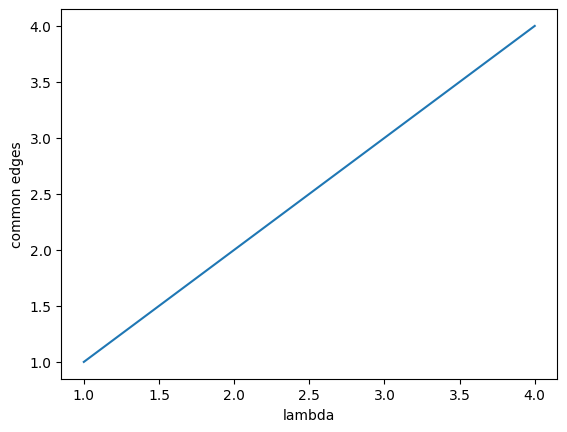

In [13]:
y = intersections_with_opt[1:]
plt.plot(lambds, y)
plt.ylabel('common edges')
plt.xlabel('lambda')

## Retrain

In [14]:
layers = 2
batch_size = 96
log_frequency = 20
channels = 16
unrolled = False
visualization = False

In [15]:
from retrain import train, validate, fixed_arch
# reload(train)

config = {
'layers' : layers,
'batch_size' : batch_size,
'log_frequency' : log_frequency,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

best_top1s = []
for lambd in [1, 2, 3, 4]:
    if lambd == 0:
        folder = config['save_folder'] + "optimal/"
    else:
        folder = config['save_folder'] + f"lambd={lambd}/"
    print(folder)
    with fixed_arch(folder + 'arc.json'):
    # with fixed_arch(args.save_folder + "/arc.json"):
        model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)

    criterion = nn.CrossEntropyLoss()

    model.to(device)
    criterion.to(device)

    optimizer = torch.optim.SGD(model.parameters(), 0.025, momentum=0.9, weight_decay=3.0E-4)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, config['epochs'], eta_min=1E-6)

    train_loader = torch.utils.data.DataLoader(dataset_train,
                                            batch_size=config['batch_size'],
                                            shuffle=True,
                                            num_workers=config['workers'],
                                            pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)

    best_top1 = 0.
    for epoch in range(config['epochs']):
        drop_prob = config['drop_path_prob'] * epoch / config['epochs']
        model.drop_path_prob(drop_prob)

        # training
        train(config, train_loader, model, optimizer, criterion, epoch)

        # validation
        cur_step = (epoch + 1) * len(train_loader)
        top1 = validate(config, valid_loader, model, criterion, epoch, cur_step)
        best_top1 = max(best_top1, top1)

        lr_scheduler.step()

    torch.save(model.state_dict(), folder + "mod.json")
    # torch.save(model.state_dict(), args.save_folder + "/mod.json")
    print("Final best Prec@1 = {:.4%}".format(best_top1))
    best_top1s.append(best_top1)
    print(best_top1s)

./checkpoints/fashionMNIST/lambd=1/
[2023-11-09 16:40:25] Fixed architecture: {'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'skipconnect', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'skipconnect', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [1], 'reduce_n4_switch': [3], 'reduce_n5_switch': [2]}
[2023-11-09 16:40:25] Epoch 0 LR 0.025000
[2023-11-09 16:40:26] Train: [  1/10] Step 000/624 Loss 3.261 Prec@(1,5) (9.4%, 50.0%)
[2023-11-09 16:40:26] Train: [  1/10] Step 020/624 Loss 2.766 Prec@(1,5) (24.3%, 71.1%)
[2023-11-09 16:40:27] Train: [  1/10] Step 040/624 Loss 2.230 Prec@(1,5) (39.1%, 83.6%)
[2023-11-09 16:40:27] Train: [  1/10] Step 060/624 Loss 1.970 Prec@(1,5) (46.3%, 88.1%)
[2023-11-09 16:40

## Validation

In [17]:
import numpy as np
from glob import glob
from nni.retiarii.oneshot.pytorch.utils import AverageMeter
from torch.utils.tensorboard import SummaryWriter

logger = logging.getLogger('nni')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

config = {
'layers' : 2,
'batch_size' : 96,
'log_frequency' : 30,
'epochs' : 10,
'aux_weight' : 0.4,
'drop_path_prob' : 0.1,
'workers' : 4,
'grad_clip' : 5.,
'save_folder' : "./checkpoints/fashionMNIST/",
}

dataset_train, dataset_valid = datasets.get_dataset("fashionmnist", cutout_length=16)

res_dict_accur = {}
models = []

# chosen_lambdas = np.random.choice(8, size=3, replace=False) # выбранные lambda
chosen_lambdas = (1, 2, 3)

print(chosen_lambdas)

# with fixed_arch(dir + "/arc.json"):
#     model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True)
#     model.to(device)
#     model.load_state_dict(torch.load(config['save_folder'] + "optimal/mod.json"))
#     model.eval()
    
#     models.append(model)

for dir in glob(config['save_folder'] + "*"):
    if dir.split('\\')[-1] != 'optimal' and float(dir.split('\\')[-1].split('=')[-1]) in chosen_lambdas:
    # if dir == "./checkpoints\\0":
        print(dir)
        with fixed_arch(dir + "/arc.json"):
            model = CNN(32, 1, 36, 10, config['layers'], auxiliary=True, n_chosen=n_chosen)
        model.to(device)
        model.load_state_dict(torch.load(dir + "/mod.json"))
        model.eval()
        
        models.append(model)

print(f"Models in ensemble: {len(models)}")

valid_loader = torch.utils.data.DataLoader(dataset_valid,
                                            batch_size=config['batch_size'],
                                            shuffle=False,
                                            num_workers=config['workers'],
                                            pin_memory=True)
criterion = nn.CrossEntropyLoss()

top1 = AverageMeter("top1")
top5 = AverageMeter("top5")
losses = AverageMeter("losses")

# validation
softmax = nn.Softmax(dim=1)
for step, (X, y) in enumerate(valid_loader):
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        bs = X.size(0)

        probabilities = softmax(models[0](X))
        for i in range(1, len(models)):
            probabilities += softmax(models[i](X))
        probabilities = probabilities / len(models)
        loss = criterion(probabilities, y)

        accuracy = utils.accuracy(probabilities, y, topk=(1, 5))
        losses.update(loss.item(), bs)
        top1.update(accuracy["acc1"], bs)
        top5.update(accuracy["acc5"], bs)

        if step % config['log_frequency'] == 0 or step == len(valid_loader) - 1:
            logger.info(
                "Valid: Step {:03d}/{:03d} Loss {losses.avg:.3f} "
                "Prec@(1,5) ({top1.avg:.1%}, {top5.avg:.1%})".format(
                    step, len(valid_loader) - 1, losses=losses,
                    top1=top1, top5=top5))

logger.info("Final best Prec@1 = {:.4%}".format(top1.avg))

res_dict_accur[chosen_lambdas] = top1.avg
print(res_dict_accur)

(1, 2, 3)
./checkpoints/fashionMNIST\lambd=1
[2023-11-09 16:55:46] Fixed architecture: {'reduce_n2_p0': 'maxpool', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'sepconv5x5', 'reduce_n3_p2': 'skipconnect', 'reduce_n4_p0': 'dilconv5x5', 'reduce_n4_p1': 'dilconv5x5', 'reduce_n4_p2': 'skipconnect', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'skipconnect', 'reduce_n5_p1': 'sepconv5x5', 'reduce_n5_p2': 'sepconv5x5', 'reduce_n5_p3': 'avgpool', 'reduce_n5_p4': 'maxpool', 'reduce_n2_switch': [1], 'reduce_n3_switch': [1], 'reduce_n4_switch': [3], 'reduce_n5_switch': [2]}
./checkpoints/fashionMNIST\lambd=2
[2023-11-09 16:55:47] Fixed architecture: {'reduce_n2_p0': 'sepconv5x5', 'reduce_n2_p1': 'dilconv5x5', 'reduce_n3_p0': 'dilconv5x5', 'reduce_n3_p1': 'dilconv5x5', 'reduce_n3_p2': 'sepconv5x5', 'reduce_n4_p0': 'avgpool', 'reduce_n4_p1': 'sepconv3x3', 'reduce_n4_p2': 'dilconv5x5', 'reduce_n4_p3': 'maxpool', 'reduce_n5_p0': 'avgpool', 'reduce_n5_p1': 'dilconv5x5', 'r

# TMP

In [69]:
from torch.distributions import RelaxedOneHotCategorical

a = torch.tensor([2, 0.5, -0.5])
b = RelaxedOneHotCategorical(logits=a, temperature=0.5).rsample().t()
b[0]

tensor(0.6498)